# Spin Evolution Model

**juliaroquette@05October2020:** There was a bug in the code for very low mass stars M<0.25M$\odot$. It was related to how I was dealing with $\tau_D$ parameters that were shorter than the minimum age of Baraffe models. I fixed that. 

**juliaroquette@28September2020** After the discussion with Sean yesterday we identified a couple of things to be checked in my code

1- The value for tau_cz(sun) in Baraffe+2015 models

2- Baraffe's definition of momentum of intertia is $I_*=k_2^2\times M_*\times R_*^2$, but inside my code that reads Baraffe models, what is return is $I_*=k_2^2\times \frac{M_*}{M_\odot}\times\big(\frac{R_*}{R_\odot}\big)^2$, so in order to to have $I_*$ in cgs, I need to multiply it by $\times M_\odot R_\odot^2$ and *NOT* by $I_\odot$ like I was doing before!

3- do I still need to adjust the conversion of Hz to $S^{-1}$?

**juliaroquette@25September2020** Yesterdaty I introduced a new way of estimating dI/dt, following Louis' hint to use scipy to get the proper derivative on the curve.
My structyre term now seems to be working correctly, but there isstill a problem with my wind. After some discussion with Louis, he told me he had some problems before related to how he defined the units of Omega in Hz, since Hz isn't necessarily equal to 1/s, and I may need a 2$\pi$ factor for this conversion. See the note below.

**juliaroquette@22September2020** There is still a problem with my wind torque. Sean called my attention to the fact that, as part of my Runge Kutta 2nd step, I need to estimate $\frac{dI}{dt}$ for the half step as well. 

**juliaroquette@16September2020** I am implementing Sean's model to be used as part of my study regarding the external photoevaporation of disks due to the presence of massive stars.

In [154]:
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import matplotlib as mpl

**Note on astropy.units** Following https://docs.astropy.org/en/stable/units/equivalencies.html

I will start by creating a base for a `class` with all function required for the model:

In [2]:
class SpinEvolutionCode:
    """
    My spin evolution code

    """

The angular momentum of a star is $J_*=I_*\Omega_*$, and its temporal evolution will be given by:

$\frac{dJ_*}{dt}=\tau$

where $\tau$ are the torques acting on the star.
Using the product rule, this can be re-written as:

$\tau=\frac{d(I_*\Omega_*)}{dt}=I_*\frac{d\Omega_*}{dt}+\Omega_*\frac{dI_*}{dt}$

From this equation, the rotation evolution of the star can be written as:

$\frac{d\Omega_*}{dt}=\frac{\tau}{I_*}-\frac{\Omega*}{I}\frac{dI_*}{dt}\;\;\;\;\;\;\;\;\mathrm{(1)}$

I will be using Sean's 2015 model, therefore my model starts with the constant values adopted in Matt et al. 2015 formulartion:

- $\chi=10$ Inverse critical Rossby number for magnetic saturation in solar units

- $p=2$ rotation activity scaling 

- $M_\odot=1.99\times10^{33}g$

- $R_\odot=6.96\times10^{10}cm$

- $\Omega_\odot=2.6\times10^{-6}Hz$

- $I_\odot=0.7\times10^{54}g\;cm^2$

- $t_\odot=4.55\times10^{9}yr$

- $\tau_{cz\odot}=12.9days$ normalization for the convective turnover time



In [3]:
def __init__(self,M):
    """
    M should be in solar masses
    Omegao should be in days
#    R should be in cm 
#    Omega should be in Hz
#    tau_cz should be in days
    """
    if M==0.1: M+=0.000001
    import astropy.units as u
    from isoc import BHAC15_MassTrack 
    from scipy.interpolate import UnivariateSpline
    #define constants
    self.chi=10.
    self.p=2.
    self.Mo=1.99e33*u.g
    self.Omegao=2.6*1e-6*u.Hz
    self.Ro=6.96e10*u.cm
    self.Io=7e53*u.g*(u.cm**2)    
    self.to=4.55e9*u.yr
    self.tau_cz_o=13.779841682644548*u.d #
    #12.9*u.d
    self.baraffe=BHAC15_MassTrack(mass=M,talkative=False)  
SpinEvolutionCode.__init__ = __init__

As a test, let's read some of the model's constants:

In [4]:
spin=SpinEvolutionCode(1.)

In [5]:
print('momentum of inertia - sun:', spin.Io)
print('Mass- sun:', spin.Mo)
print('Radius- sun:', spin.Ro)
print('Baraffe units?',spin.Io/(spin.Mo*spin.Ro*spin.Ro))

momentum of inertia - sun: 7e+53 cm2 g
Mass- sun: 1.99e+33 g
Radius- sun: 69600000000.0 cm
Baraffe units? 0.07261502385756236


## Assumption 1: 

During the duration of the star-disk interaction, which is described by $\tau_D$, the rotation of the star is constant.

$\frac{d\Omega_*}{dt}=0$ and this implies that $\frac{\tau}{I_*}=\frac{\Omega*}{I}\frac{dI_*}{dt}$, which is the same as saying that the torques in action will compensate the Pre Main Sequence Contraction.

First step is therefore deriving $\frac{dI_*}{dt}$ values and I will do that using the Baraffe et al. 2015 models. <- In the future I will try to migrate the code to MESA, but MIST currently doesn't give $I$ and I would have to learn how run the MESA evolution code which will take a longer timescale and will be done in a second phase of this project. 

I previously created a `class` called `BHAC15_MassTrack`, inside my `isoc` package (reads isochrones from different models), which loads Baraffe et al. 2015 mass tracks

In [6]:
from isoc import BHAC15_MassTrack 

For plotting purposes

In [7]:
MT=[]
for i,mass in enumerate([1.400,1.000,0.800,0.500,0.300,0.250,0.200,0.100]):
    MT.append(BHAC15_MassTrack(mass=mass,talkative=False))
    print("index={0}, Mass={1}Mo".format(i,MT[-1].Mass[0]))

index=0, Mass=1.4Mo
index=1, Mass=1.0Mo
index=2, Mass=0.8Mo
index=3, Mass=0.5Mo
index=4, Mass=0.3Mo
index=5, Mass=0.25Mo
index=6, Mass=0.2Mo
index=7, Mass=0.1Mo


This shows $I_*$ as a function of age. Note that for masses below 0.2M$\odot$ $I_*$ remains almost constant few Myrs. 

[Text(0, 0, '1'),
 Text(0, 0, '10'),
 Text(0, 0, '100'),
 Text(0, 0, '1000'),
 Text(0, 0, '10000')]

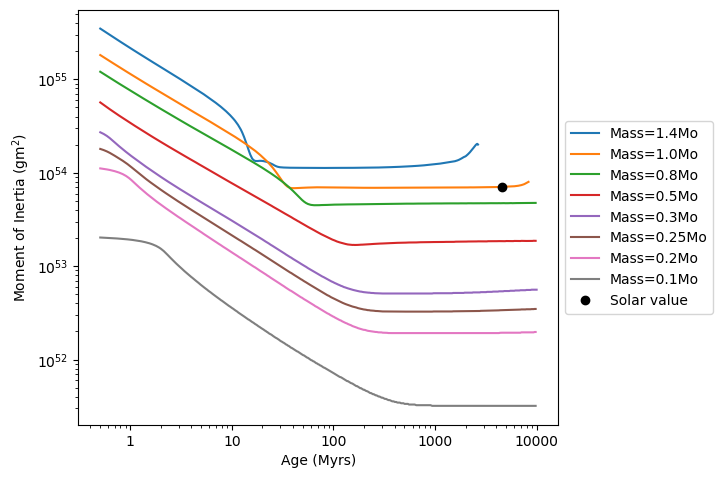

In [8]:
fig, axis = plt.subplots(1,1,figsize = (8,5),dpi=100,sharey=True,sharex=True)
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for mt in MT:
    axis.plot(mt.Age/1e6,mt.I*spin.Mo*spin.Ro**2,label='Mass='+str(mt.Mass[0])+'Mo')
axis.plot(spin.to.to(u.yr).value/1e6,spin.Io,'ko',label='Solar value')
axis.set_xlabel('Age (Myrs)')
axis.set_ylabel(r'Moment of Inertia (gm$^2$)')
axis.set_xscale("log")
axis.set_yscale("log")
axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axis.set_xticks([1,10,100,1000,10000])
axis.set_xticklabels([1,10,100,1000,10000])
#plt.savefig('/Users/jroquette/work/plot/IvsAge.png')

This give me a notion of the typical variation of $I_*$ between two consecutive timesteps in the Baraffe models.

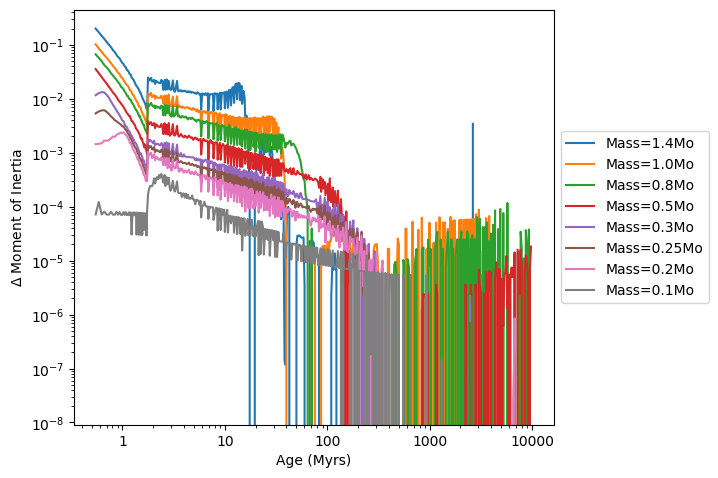

In [9]:
fig, axis = plt.subplots(1,1,figsize = (8,5),dpi=100,sharey=True,sharex=True)
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for mt in MT:
    axis.plot(mt.Age[1:]/1e6,mt.I[:-1]-mt.I[1:],label='Mass='+str(mt.Mass[0])+'Mo')
axis.set_xlabel('Age (Myrs)')
axis.set_ylabel(r'$\Delta$ Moment of Inertia')
axis.set_xscale("log")
axis.set_yscale("log")
axis.set_xticks([1,10,100,1000,10000])
axis.set_xticklabels([1,10,100,1000,10000])
axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

This gives me a notion of the size of the timesteps in the Baraffe models. Note that I used linear-interpolation to resample all the mass tracks in order to force them having the sime time steps.

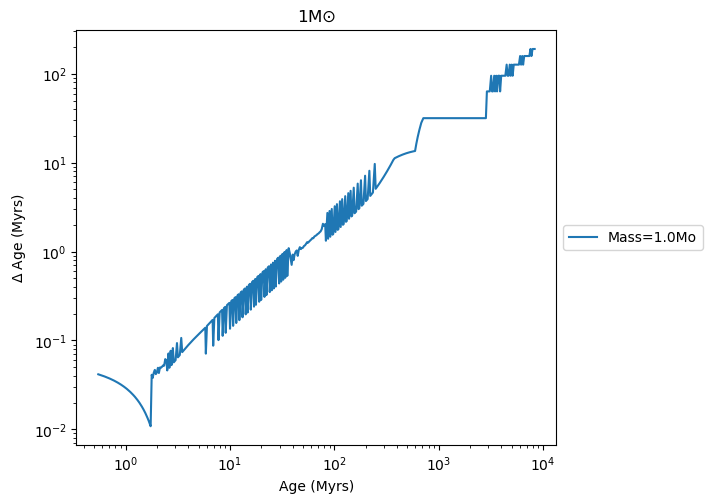

In [10]:
fig, axis = plt.subplots(1,1,figsize = (8,5),dpi=100,sharey=True,sharex=True)
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)
mt =MT[1] # solar mass
axis.plot(mt.Age[1:]/1e6,mt.Age[1:]/1e6-mt.Age[:-1]/1e6,'-',label='Mass='+str(mt.Mass[0])+'Mo')
axis.set_xlabel('Age (Myrs)')
axis.set_ylabel(r'$\Delta$ Age (Myrs)')
axis.set_xscale("log")
axis.set_yscale("log")
axis.set_title(r"1M$\odot$")
axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

This shows the variation of Effective Temperature as a function of age. Note that the solar value, 5778 K, doesn't exactly match the Baraffe model for 1M$\odot$. This is because the Baraffe 2015 models **are not** callibrated to exactly match Sun. Because of that, I had to re-estimate $\tau_{cz\odot}$ to correspond to the temperature of a star of 1M$\odot$ at the age of the Sun in Baraffe+2015 models. 

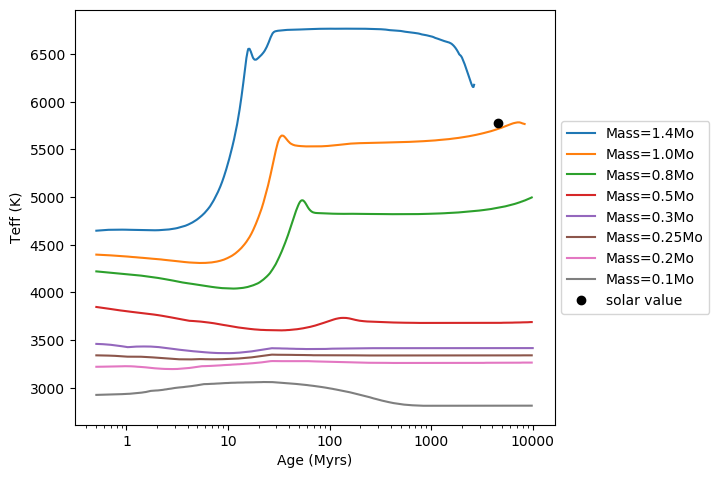

In [11]:
fig, axis = plt.subplots(1,1,figsize = (8,5),dpi=100,sharey=True,sharex=True)
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for mt in MT:
    axis.plot(mt.Age/1e6,mt.Teff,label='Mass='+str(mt.Mass[0])+'Mo')
axis.plot(spin.to.value/1e6,5778,'ko',label='solar value')
axis.set_xlabel('Age (Myrs)')
axis.set_ylabel('Teff (K)')
axis.set_xscale("log")
axis.set_xticks([1,10,100,1000,10000])
axis.set_xticklabels([1,10,100,1000,10000])
axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Convective turnover time, $\tau_{cz}$ can be estimated from Cranmer&Saar 2011 equation (36):

$\tau_{cz}=314.24\exp\Bigg[-\Big(\frac{T_{eff}}{1952.5 K}\Big)-\Big(\frac{T_{eff}}{6250K}\Big)^{18}\Bigg] + 0.002$

In [12]:
def tau_cz_CS11(self,T):
    """
    Derives the convective turnover timescale as in Cranmer & Saar 2011
    """
    return (314.24*np.exp(-(T/1952.5)-(T/6250)**18)+0.002)*u.d
SpinEvolutionCode.tau_cz_CS11 = tau_cz_CS11

$\chi\equiv\frac{R_{o\odot}}{R_{oSAT}}\equiv\frac{\Omega_{oSAT}\tau_{cz}}{\Omega_{o\odot}\tau_{cz\odot}}$, where $R_o\equiv\frac{1}{\Omega_*\tau_{cz}}$ is the Rossby number

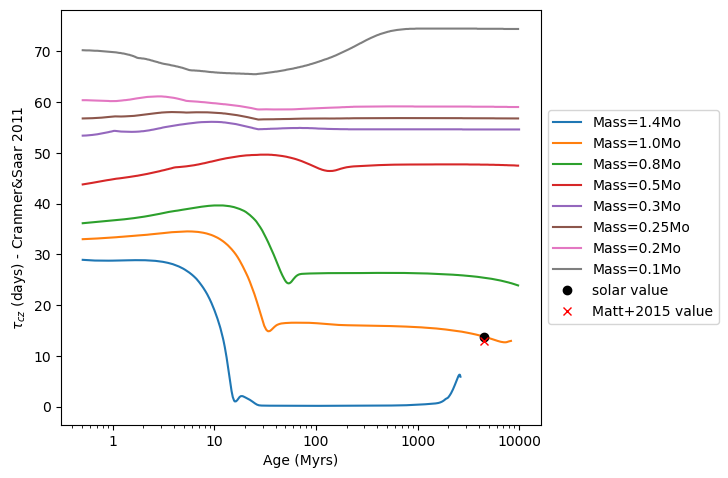

In [13]:
fig, axis = plt.subplots(1,1,figsize = (8,5),dpi=100,sharey=True,sharex=True)
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

for mt in MT:
    axis.plot(mt.Age/1e6,spin.tau_cz_CS11(mt.Teff),label='Mass='+str(mt.Mass[0])+'Mo')
axis.plot(spin.to.value/1e6,spin.tau_cz_o,'ko',label='solar value')
axis.plot(spin.to.value/1e6,12.9,'rx',label='Matt+2015 value')
axis.set_xlabel('Age (Myrs)')
axis.set_ylabel(r'$\tau_{cz}$ (days) - Cranmer&Saar 2011')
axis.set_xscale("log")
axis.set_xticks([1,10,100,1000,10000])
axis.set_xticklabels([1,10,100,1000,10000])
axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Next, I need a way to use these models to interpolate the parameters of a star with any mass $M$ in the range $0.1\leq M\leq1.4M\odot$.
~This will also include an estimation for the term $\frac{dI}{dt}$ in equation (1), which I will estimate as $\frac{dI}{dt}=\frac{\Delta I}{\Delta t}$ using the same $t$ and $I_*$ used for interpolating the instant values for the star.~
I added a "cheat" in this interpolation for cases in which the age is out of the Baraffe+15 range: I use the values of the model for the extremities of the range to do a linear fit and derive values from this line. Of course this will only work for values very close to the limit ages of the model and I am thus printing a warning everytime I use this approach.

In [14]:
def interpolateBaraffe(self,t,baraffe):
    """
    given a time t in yrs, interpolate parameters
    of interest from Baraffe+2015 models

    --
    input:
    t: time in yrs
    baraffe: Baraffe+15 mass track 
             baraffe=BHAC15_MassTrack(mass=M)
    --
    output:
    M,R,I,tau_cz
    """
    M=np.nan
    R=np.nan
    I=np.nan
    Teff=np.nan
    tau_cz=np.nan
    if (t>np.nanmin(baraffe.Age)) & (t<np.nanmax(baraffe.Age)):
        offset=abs(baraffe.Age-t)
        i=np.argsort(offset)[0]
        age_a=baraffe.Age[i]
        if age_a>t:
            i_=i-1
            a=0
        else:
            i_=i+1
            a=1
        if a==0: x=[baraffe.Age[i_],baraffe.Age[i]]
        else: x=[baraffe.Age[i],baraffe.Age[i_]]
        # Teff

        if a==0: y=[baraffe.Teff[i_],baraffe.Teff[i]]
        else:  y=[baraffe.Teff[i],baraffe.Teff[i_]]
        Teff=np.interp(t,x,y)
        # Mass
        if a==0: y=[baraffe.Mass[i_],baraffe.Mass[i]]
        else: y=[baraffe.Mass[i],baraffe.Mass[i_]]
        M=np.interp(t,x,y)
        # Radius
        if a==0:  y=[baraffe.R[i_],baraffe.R[i]]
        else: y=[baraffe.R[i],baraffe.R[i_]]
        R=np.interp(t,x,y) 
        # tau_cz
        tau_cz=self.tau_cz_CS11(Teff)
        # Momentum of Inertia
        if a==0: y=[baraffe.I[i_],baraffe.I[i]] 
        else: y=[baraffe.I[i],baraffe.I[i_]] 
        I=np.interp(t,x,y)                               
    elif (t<np.nanmin(baraffe.Age)):
        print('Warning! I am using a linear interpoletaion below Baraffe+15 time span!')
        x=baraffe.Age[0:4]
        y=baraffe.Teff[0:4]
        p=np.polyfit(x,y,1)
        Teff=p[0]*t+p[1]
        #
        y=baraffe.Mass[0:4]
        p=np.polyfit(x,y,1)
        M=p[0]*t+p[1]
        #
        y=baraffe.R[0:4]
        p=np.polyfit(x,y,1)
        R=p[0]*t+p[1] 
        # tau_cz
        tau_cz=self.tau_cz_CS11(Teff)
        # Momentum of Inertia
        y=baraffe.I[0:4]
        p=np.polyfit(x,y,1)
        I=p[0]*t+p[1]                        
    elif (t>np.nanmax(baraffe.Age)):
        print('Warning! I am using a linear interpoletaion above Baraffe+15 time span!')
        x=baraffe.Age[-4:]
        y=baraffe.Teff[-4:]
        p=np.polyfit(x,y,1)
        Teff=p[0]*t+p[1]
        #
        y=baraffe.Mass[-4:]
        p=np.polyfit(x,y,1)
        M=p[0]*t+p[1]
        #
        y=baraffe.R[-4:]
        p=np.polyfit(x,y,1)
        R=p[0]*t+p[1] 
        # tau_cz
        tau_cz=self.tau_cz_CS11(Teff)
        # Momentum of Inertia
        y=baraffe.I[-4:]
        p=np.polyfit(x,y,1)
        I=p[0]*t+p[1]                        
    return M,R,I,Teff,tau_cz#,dIdt

SpinEvolutionCode.interpolateBaraffe = interpolateBaraffe

Let's test the code until here. The first example show where I took the new value of $\tau_{cz\odot}$ from

In [15]:
spin=SpinEvolutionCode(1)
M,R,I,T,tau_cz=spin.interpolateBaraffe(4.56e9,spin.baraffe)
print(M,R,I,T)
print('k = {0} for the Sun'.format(I/(M*R**2)))
print(' I {0} from Baraffe Model, {1} from Matt+2015'.format(I*spin.Mo*spin.Ro**2,spin.Io))
print('tau_cz = {0} for the Sun'.format(spin.tau_cz_CS11(T)))

1.0 1.011115598015182 0.07324694052251336 5715.693997054463
k = 0.07164532696683466 for the Sun
 I 7.060915998090613e+53 cm2 g from Baraffe Model, 7e+53 cm2 g from Matt+2015
tau_cz = 13.77367499891107 d for the Sun


In [16]:
spin=SpinEvolutionCode(.1)
M,R,I,T,tau_cz=spin.interpolateBaraffe(4.56e9,spin.baraffe)
print(M,R,I,T)
print('k = {0} '.format(I/(M*R**2)))
print(' I {0} from Baraffe Model, {1} from Matt+2015'.format(I*spin.Mo*spin.Ro**2,spin.Io))
print('tau_cz = {0} for the Sun'.format(spin.tau_cz_CS11(T)))

0.100001 0.12400094 0.000331761246377865 2811.00451
k = 0.21576021005300183 
 I 3.198138072915059e+51 cm2 g from Baraffe Model, 7e+53 cm2 g from Matt+2015
tau_cz = 74.47684717245785 d for the Sun


In [17]:
spin=SpinEvolutionCode(1.4)
M,R,I,T,tau_cz=spin.interpolateBaraffe(4.56e9,spin.baraffe)
print(M,R,I,T)
print('k = {0} '.format(I/(M*R**2)))
print(' I {0} from Baraffe Model, {1} from Matt+2015'.format(I*spin.Mo*spin.Ro**2,spin.Io))
print('tau_cz = {0} for the Sun'.format(spin.tau_cz_CS11(T)))

Warning! I am using a linear interpoletaion above Baraffe+15 time span!
1.400000000000006 2.779927802534406 0.19185884817139578 6469.185752971258
k = 0.01773318574789647 
 I 1.8494959663363175e+54 cm2 g from Baraffe Model, 7e+53 cm2 g from Matt+2015
tau_cz = 1.7829214911353284 d for the Sun


Initially I did a estimation of $\frac{dI}{dt}$ as $\frac{\Delta I}{\Delta t}$ at ($t_i,t_{i+1}$), but later Louis gave me a hint on how to improve this estimation by using a spline interpolation to derive the derivative of the curve at any desired point. 

Thiscan be done with `UnivariateSpline.derivative`: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.UnivariateSpline.derivative.html

In [18]:
def dIdt(self,t):    
    """
    calculates the derivative dI/dt at a position t
    """
    if not isinstance(t, type(1*u.yr)):
        t=(t*u.yr)
    from scipy.interpolate import UnivariateSpline
    y=self.baraffe.I*self.Mo*self.Ro**2
    x=(self.baraffe.Age*u.yr).to(u.s)
    spl = UnivariateSpline(x, y, k=4)
    return spl.derivative(n=1)(t.to(u.s).value)*(u.cm**2)*u.g/u.s
SpinEvolutionCode.dIdt = dIdt

In [19]:
spin=SpinEvolutionCode(1)
print('At the age of the sun',spin.dIdt(spin.to))

At the age of the sun 1.6321293977155039e+35 cm2 g / s


/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [20]:
spin=SpinEvolutionCode(0.1)
print('At the age of the sun',spin.dIdt(spin.to))

At the age of the sun 4.431793819834026e+27 cm2 g / s


No handles with labels found to put in legend.


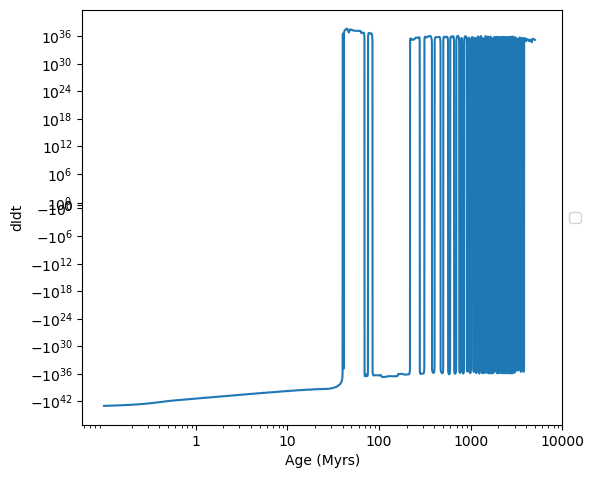

In [21]:
fig, axis = plt.subplots(1,1,figsize = (8,5),dpi=100,sharey=True,sharex=True)
plt.subplots_adjust(left=0.15, right=0.75, bottom=0.12, top=0.95)
plt.subplots_adjust(wspace=0., hspace=0)

spin=SpinEvolutionCode(1)
axis.plot(np.linspace(1e5,5e9,100000)/1e6,spin.dIdt(np.linspace(1e5,5e9,100000)))
axis.set_xlabel('Age (Myrs)')
axis.set_ylabel('dIdt')
axis.set_xscale("log")
axis.set_yscale("symlog")
axis.set_xticks([1,10,100,1000,10000])
axis.set_xticklabels([1,10,100,1000,10000])
axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Assumption 2: 

After $\tau_D$, the only torque in action is the stellar wind ($\tau=\tau_W$). For these torques, I will adopt Matt et al. 2015 torques as follow. 

$\tau_W=-T_o\Big(\frac{\tau_{cz}}{\tau_{cz\odot}}\Big)^p\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)^{p+1}$ in the unsaturated regime

$\tau_W=-T_o\chi^p\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)$  in the saturated regime 

where:
    
$T_o=T_o(T_\odot,M_*,R_*)=\frac{2}{3}9.5\times10^{30}\mathrm{erg}\Big(\frac{R_*}{R_\odot}\Big)^{3.1}\Big(\frac{M_*}{M_\odot}\Big)^{0.5}$, and 


In [22]:
def To(self,M,R):
    """
    input
    M in Mo
    R in Ro
    """
    return 6.3e30*u.erg*((R)**3.1)*((M)**0.5)
SpinEvolutionCode.To = To

Now, using these definitions we have:

$\tau_W=-T_o\Big(\frac{\tau_{cz}}{\tau_{cz\odot}}\Big)^2\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)^{3}$ in the unsaturated regime

$\tau_W=-100T_o\Big(\frac{\Omega_*}{\Omega_{\odot}}\Big)$  in the saturated regime 

And we can code that in terms of $\Omega_*$ and $\tau_{cz}$.

Now, $\chi=10$ gives us means to define what is the saturated regime:

$\chi=1=\frac{\Omega_{oSAT}\tau_{cz}}{\Omega_{o\odot}\tau_{cz\odot}}$, and so $\Omega_\mathrm{SAT}=10\frac{\Omega_\odot\tau_{cz\odot}}{\tau_{cz}}$

**Note that** I want my model to be in terms of $\Omega_\odot$ so $\Omega\rightarrow\frac{\Omega}{\Omega_\odot}$

$\tau_W=-T_o\Big(\frac{\tau_{cz}}{\tau_{cz\odot}}\Big)^2\Big(\Omega\Big)^{3}$ in the unsaturated regime

$\tau_W=-100T_o\Big(\Omega\Big)$  in the saturated regime 

In [23]:
def tau_w(self,Omega,M=1,R=1,T=1):
    """
    M and Omega are input to the code, R and T come from the Baraffe Model. 
    M,R and Omega are in solar units
    """
    if not isinstance(Omega, type(1*u.Hz)):
         Omega=Omega*self.Omegao      
    if Omega<(self.chi*self.Omegao*self.tau_cz_o/self.tau_cz_CS11(T)):
        return -self.To(M,R)*((self.tau_cz_CS11(T)/self.tau_cz_o)**self.p)*((Omega/self.Omegao)**(self.p+1))
    else:
        return -self.To(M,R)*(self.chi**self.p)*(Omega/self.Omegao) 
SpinEvolutionCode.tau_w = tau_w

Finally, I need a numerical method to solve equation (1). In `BasicSpinEvolution_Dec2018.ipynb` I tested the Euler method and Runge Kutta 2nd and 4th order. But I will keep it simple and use the Euler method. 

### Euler Method

(Some References: 
https://en.wikipedia.org/wiki/Euler_method
Book: A Primer on Scientific Programming with Python - Hans Petter Langtangen https://hplgit.github.io/) 

First-order numerical procedure for solving ordinary differential equations given an initial value. Given:

$y'(t)=f(t,y(t)),\;\;$ and $\;\;y(t_o)=y_o$

Aproximate solution at a time $t_{i+1}$: 
$y_{i+1}=y_i+\Delta tf(y_k,t_k)$, with $\Delta t=t_{i+1}-t_i$

##### Example :

$\frac{dy}{dt}=y\;\;\;\;\;\;\;$ $y\rightarrow$`f`

with $y(0)=1\;\;\;\;\;\;\;$ $1\rightarrow$`Y0`

$\int\limits^y_{1}\frac{dy}{y}=\int\limits^t_{0}dt$

$\ln{y}=t$

$y(t)=e^t\;\;\;\;$  (exact solution)

Will solve it from 0 to 3, thus T -> 3

In the case of the rotational evolution equation:

$y'(t)=f(t,y(t))\rightarrow\frac{d\Omega}{dt}$

$\frac{d\Omega}{dt}=\frac{\tau_W}{I}-\frac{\Omega}{I}\times\frac{dI}{dt}$

Now, there are a couple of things in this equation that will also change with time. $\tau_W=\tau_W(\Omega(t),M,R)$ and $\frac{dI}{dt}$ will both be time dependent, but in a way that is already tabulated. 

Additionally, I don't want the timesteps to be fixed. First, because I don't really need to estimate omega in the whole 1Myr to 5Gyr time range. Second, because I want to guarantee I can take snapshots of the model in key ages I set up (1Myr, 2Myr, 3Myr, etc).

To deal with that, I need to introduce a variable timestep, `dt`, to the Euler method. 

The first step for that is to code a function that applies the Euler method for a single time step, with `dt` inputted to this function and defined outisde the function.

In [24]:
def Euler_(self,f,Omega,mass,t0,t,wind=True,structure=True):
    """
    Estimates one step of the Euler method
    """
    if not isinstance(Omega, type(1*u.Hz)):
         Omega=Omega*self.Omegao    
    if not isinstance(t, type(1*u.year)):
         t=t*u.year
    if not isinstance(t0, type(1*u.year)):
         t0=t0*u.year     
    dt=(t-t0)
    return Omega+dt*self.f(Omega,mass,t0,t,wind=wind,structure=structure),t0+dt
SpinEvolutionCode.Euler_ = Euler_

**Note that everytime a $f(y_k,t_k)$ is calculated, one set of $I,M,R(t_k)$ is required.** This possibility needs to be incorportated in the code

Also, I want to have the flexibility of turning off some of the terms of the equation, so I will code a $f(y,t)=f_W(y,t)+f_{dIdt}(y,t)$, instead of the simply $f(y,t)$ I currently have.

We will be looking at a star of given mass, let's say:

In [25]:
def f_W(self,Omega,mass,t0,t):
    """
    Wind torque term of the rotation evolution equation
    Omega is the rotation rate in solar units
    Mass is the mass of the star in solar units
    t is the time in which the torque is being calculated
      if no unit is given for y, I am ssuming this is in years
    """
    if not isinstance(Omega, type(1*u.Hz)):
         Omega=Omega*self.Omegao    
    if not isinstance(t0, type(1*u.year)):
         t0=t0*u.year
    M0,R0,I0,T0,tau_cz0=self.interpolateBaraffe(t0.value,self.baraffe)             
    return (self.tau_w(Omega,M0,R0,T0)/(I0*self.Mo*self.Ro**2))
SpinEvolutionCode.f_W = f_W

For this terms, since I want my model to be in terms of $\Omega_\odot$:


$-\frac{\Omega}{I}\times\frac{dI}{dt}\rightarrow-\frac{\Omega\Omega\odot}{I}\times\frac{dI}{dt}$
Note that both $I$ and $dI$ are in terms of $I\odot$, so this term will cancel out - including their units

In [26]:
def f_dIdt(self,Omega,mass,t0,t):
    """
    Variation in the Momentum of Ineria
    
    """
    if not isinstance(Omega, type(1*u.Hz)):
         Omega=Omega*self.Omegao          
    if not isinstance(t, type(1*u.year)):
         t=t*u.year
    if not isinstance(t0, type(1*u.year)):
         t0=t0*u.year
    M0,R0,I0,T0,tau_cz0=self.interpolateBaraffe(t0.value,self.baraffe)        
    return -Omega*self.dIdt(t0)/(I0*self.Mo*self.Ro**2)
SpinEvolutionCode.f_dIdt = f_dIdt

In [27]:
def f(self,Omega,mass,t0,t,wind=True,structure=True):
    if bool(wind) and bool(structure):
        return self.f_W(Omega,mass,t0,t)+self.f_dIdt(Omega,mass,t0,t)
    elif not bool(wind) and bool(structure):
        return self.f_dIdt(Omega,mass,t0,t)
    elif bool(wind) and not bool(structure):
        return self.f_W(Omega,mass,t0,t) 
SpinEvolutionCode.f=f    

Note on the variable timestep:

We want to know how much is the $d\Omega$ that will increase $\Omega$ by a certain factor $e$, so

$e=\frac{d\Omega}{\Omega}\rightarrow d\Omega=e\Omega$

We have to look each term of the differential equation serparately, otherwise Sean said it will introduce a bug in the code in the part of the rotational evolution curve in which $\frac{d\Omega}{dt}=0$.

for the first term:

$\frac{d\Omega}{dt}=\frac{\tau}{I}\rightarrow d\Omega=\frac{\tau}{I}dt$

So: $e\Omega=\frac{\tau}{I}dt\rightarrow dt=e\Omega\frac{I}{\tau}$

For the structure term:

$\frac{d\Omega}{dt}=-\frac{\Omega}{I}\frac{dI}{dt}\rightarrow d\Omega=-\frac{\Omega}{I}\frac{dI}{dt}dt=e\Omega$

$dt=-\frac{eI}{\frac{dI}{dt}}$

Finally, this function will deal with the different terms of the equation and decide which of the terms contributes more and estimate $dt$ accordingly.

In [28]:
def get_dt(self,Omega,t0,e,structure=True,wind=True):
    """
    estimates the ideal timestep
    """
    if not isinstance(t0, type(1*u.yr)):
        t0=t0*u.yr    
    if not isinstance(Omega, type(1*u.yr)):
        Omega=Omega*self.Omegao
    M,R,I,T,tau_cz=self.interpolateBaraffe(t0.value,self.baraffe)
    if bool(wind) and bool(structure):
        dt_s=-e*I*self.Mo*(self.Ro**2)/self.dIdt(t0)
        dt_w=e*I*self.Mo*(self.Ro**2)*(Omega)/self.tau_w(Omega,M,R,T)
        return min(abs(dt_s),abs(dt_w)).to(u.yr)
    elif not bool(wind) and bool(structure):
        return abs(e*I*self.Mo*(self.Ro**2)/self.dIdt(t0))
    elif bool(wind) and not bool(structure):
        return abs(e*I*self.Mo*(self.Ro**2)*(Omega)/self.tau_w(Omega,M,R,T))        
SpinEvolutionCode.get_dt = get_dt

This test the `get_dt` function:

In [29]:
Omega=10*spin.Omegao
to=1e6
mass=1
spin=SpinEvolutionCode(mass)
e=0.01
print(spin.get_dt(Omega,to,e)/1e6)

0.014698734804489647 yr


/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [30]:
Omega=10*spin.Omegao
to=1e8
mass=1
spin=SpinEvolutionCode(mass)
e=0.01
print(spin.get_dt(Omega,to,e)/1e6)

1.2560956560462337 yr


Now, the final touch is that I want to be able to get snapshots of the model at ages of interest. The code below solves the differential equation and also deals with **Assumption 1** by keeping the star with constant rotation if the `tau_d` flag is different from zero.

In [43]:
def dOmegadt(self,mass,Omega0,t0,t,tau_d=0,e=0.1,wind=True,structure=True,snapshot=False):
    """
    __
    input
    _
    mass: stellar mass in solar masses
    Omega0: initial rotation
    t0: initial time
    t: vector with the key timesteps
    e: [0,1] tolerance of minimal variation of Omega do define a intermediary timestep
    wind: [True] for activate wind term
    structure: [True] for activate structure term    
    snapshot: [True] the model will return only data for the timesteps listed in t
    __
    output
    _
    
    """
    t=np.array(t)
    if not isinstance(Omega0, type(1*u.Hz)):
        Omega0=Omega0*self.Omegao
    if not isinstance(t0, type(1*u.yr)):
        t0=t0*u.yr
    if not isinstance(t, type(1*u.yr)):
        t=t*u.yr    
    if t0.value < np.nanmin(self.baraffe.Age):
        t0=(np.nanmin(self.baraffe.Age)+5e4)*u.yr
        print('Minimum value must be inside the age range of the Baraffe Model')
    for i,T in enumerate(t):
        if T.value>np.nanmax(self.baraffe.Age): #makes sure I am not going after Baraffe's models    
            t[i]=(np.nanmax(self.baraffe.Age)-1e6)*u.yr
            print('Maximum value must be inside the age range of the Baraffe Model')
    if not isinstance(tau_d, type(1*u.yr)):
        tau_d=tau_d*u.yr 
    if (tau_d!=0) & (tau_d.value<1e5):
        print(r'Is $\tau_D$ in the right units?')
    t_=[]
    Omega_=[]
    t_.append(t0.value)
    Omega_.append(Omega0/self.Omegao)
    tk_o=1.*t0
    n=0
    # test if tau_D is before t0:
    if tau_d>t0:
        while t[n]<tau_d: 
            t_.append(t[n].value)
            Omega_.append(Omega0/self.Omegao)
            tk_o=t[n]
            n+=1
        #next register the moment disk was lost:                
        if not bool(snapshot): 
            t_.append(tau_d.value)
            Omega_.append(Omega0/self.Omegao)
        tk_o=tau_d    
    dt=self.get_dt(Omega0,tk_o,e,wind=wind,structure=structure) 
    for T in t[n:]:
        while tk_o+dt < T:    
            tk_=tk_o+dt
            O,tk=self.Euler_(self.f, Omega0,mass, tk_o,tk_,wind=wind,structure=structure)  
            if not bool(snapshot):
                t_.append(tk.value)
                Omega_.append(O/self.Omegao)
            Omega0=1.*O
            tk_o=tk            
            dt=self.get_dt(Omega0,tk_o,e,wind=wind,structure=structure)
        tk_=T       
        O,tk=self.Euler_(self.f, Omega0,mass, tk_o,tk_,wind=wind,structure=structure)  
        t_.append(tk.value)
        Omega_.append(O/self.Omegao)
        Omega0=1.*O
        tk_o=tk            
        dt=self.get_dt(Omega0,tk_o,e,wind=wind,structure=structure)
    return np.array(t_),np.array(Omega_)
SpinEvolutionCode.dOmegadt = dOmegadt

This example shows the models for two different masses and considering only the structure term. 

In [65]:
to=.5e6
e=0.05
t=[5e9]
spin=SpinEvolutionCode(1.)
t_1p0,Omega_1p0=spin.dOmegadt(1.0,10*spin.Omegao,to,[1e6,5e9],e=e,structure=True,wind=False)
spin=SpinEvolutionCode(0.3)
t_0p3,Omega_0p3=spin.dOmegadt(0.3,10*spin.Omegao,to,[1e6,5e9],e=e,structure=True,wind=False)

Minimum value must be inside the age range of the Baraffe Model


/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Minimum value must be inside the age range of the Baraffe Model


[Text(0, 0, '1'), Text(0, 0, '10'), Text(0, 0, '100')]

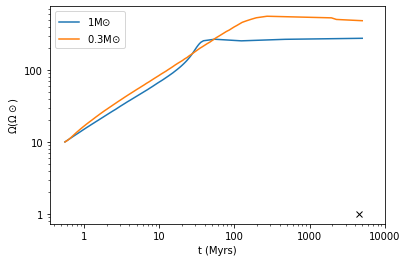

In [66]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
plt.plot(t_1p0/1e6,Omega_1p0,'-',label=r'1M$\odot$')
plt.plot(t_0p3/1e6,Omega_0p3,'-',label=r'0.3M$\odot$')
plt.plot(spin.to/1e6,1,'kx')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
#ax.set_xlim(0,1)
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test_structure_dIdt_fixed.png')

Next, this other example shows the models for only the wind term and two different masses

In [48]:
to=.5e6
e=0.05
t=[5e9]
spin=SpinEvolutionCode(1.)
t_1p0,Omega_1p0=spin.dOmegadt(1.0,10*spin.Omegao,to,t,e=e,structure=False)

Minimum value must be inside the age range of the Baraffe Model


In [49]:
len(t_1p0)

48

In [50]:
spin=SpinEvolutionCode(0.3)
t_0p3,Omega_0p3=spin.dOmegadt(0.3,10*spin.Omegao,to,t,e=e,structure=False)

Minimum value must be inside the age range of the Baraffe Model


In [51]:
len(t_0p3)

56

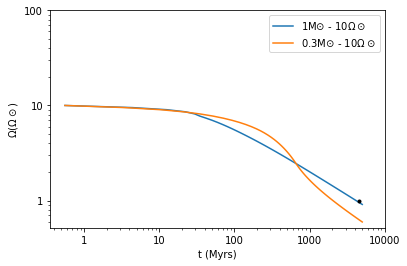

In [52]:
#e=0.01
plt.plot(t_1p0/1e6,Omega_1p0,'-',label=r'1M$\odot$ - 10$\Omega\odot$')
plt.plot(t_0p3/1e6,Omega_0p3,'-',label=r'0.3M$\odot$ - 10$\Omega\odot$')
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
#plt.show()
plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test_wind.png')

Finally, this example shows models for 1M$\odot$ starting with two different rotation, showing that the models are correctly converging to solar rotation at older ages.

In [53]:
to=.5e6
e=0.01
t=[5e9]
spin=SpinEvolutionCode(1.)
t_1p0,Omega_1p0=spin.dOmegadt(1.0,10*spin.Omegao,to,t,e=e)
t_1p0_,Omega_1p0_=spin.dOmegadt(1.0,30*spin.Omegao,to,t,e=e)

Minimum value must be inside the age range of the Baraffe Model


/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Minimum value must be inside the age range of the Baraffe Model


In [54]:
len(t_1p0)

848

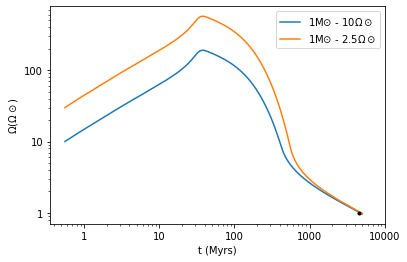

In [55]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
plt.plot(t_1p0/1e6,Omega_1p0,'-',label=r'1M$\odot$ - 10$\Omega\odot$')
plt.plot(t_1p0_/1e6,Omega_1p0_,'-',label=r'1M$\odot$ - 2.5$\Omega\odot$')
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
#plt.show()
plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

### testing Assumption 1:

Here, I will stest the assumption one for different $\tau_D$.

First, for a 1M$\odot$ star with, and without disk-locking.

In [113]:
to=.5e6
e=0.01
t=[5e9]
spin=SpinEvolutionCode(1.)
t_1p0,Omega_1p0=spin.dOmegadt(1.0,10,to,t,e=e)

Minimum value must be inside the age range of the Baraffe Model


/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [114]:
t_1p0_,Omega_1p0_=spin.dOmegadt(1.0,10*spin.Omegao,to,t,tau_d=5e6,e=e)

Minimum value must be inside the age range of the Baraffe Model


In [115]:
t_1p0__,Omega_1p0__=spin.dOmegadt(1.0,1*spin.Omegao,to,t,tau_d=1e6,e=e)

Minimum value must be inside the age range of the Baraffe Model


In [117]:
t_1p0___,Omega_1p0___=spin.dOmegadt(1.0,1*spin.Omegao,to,t,tau_d=10e6,e=e)

Minimum value must be inside the age range of the Baraffe Model


In [118]:
print(len(t_1p0),len(t_1p0_))

848 564


[Text(0, 0, '1'), Text(0, 0, '10'), Text(0, 0, '100')]

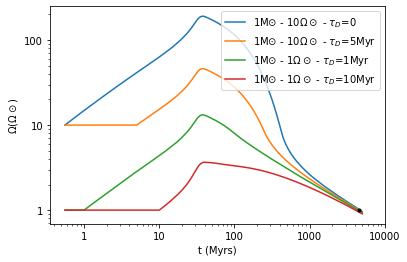

In [119]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
plt.plot(t_1p0/1e6,Omega_1p0,'-',label=r'1M$\odot$ - 10$\Omega\odot$ - $\tau_D$=0')
plt.plot(t_1p0_/1e6,Omega_1p0_,'-',label=r'1M$\odot$ - 10$\Omega\odot$ - $\tau_D$=5Myr')
plt.plot(t_1p0__/1e6,Omega_1p0__,'-',label=r'1M$\odot$ - 1$\Omega\odot$ - $\tau_D$=1Myr')
plt.plot(t_1p0___/1e6,Omega_1p0___,'-',label=r'1M$\odot$ - 1$\Omega\odot$ - $\tau_D$=10Myr')
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
#ax.set_xlim(0,6)
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

Second, this shows the evolution of a 0.1M$\odot$ star with and without disk-locking:

In [67]:
to=.5e6
e=0.01
t=[5e9]
spin=SpinEvolutionCode(0.1)
t_1p0,Omega_1p0=spin.dOmegadt(0.1,10,to,t,tau_d=0,e=e)

Minimum value must be inside the age range of the Baraffe Model


/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [61]:
t_1p0_,Omega_1p0_=spin.dOmegadt(1.0,10*spin.Omegao,to,t,tau_d=0.7e6,e=e)

Minimum value must be inside the age range of the Baraffe Model


In [62]:
t_1p0__,Omega_1p0__=spin.dOmegadt(0.1,10*spin.Omegao,to,t,tau_d=1.5e6,e=e)

Minimum value must be inside the age range of the Baraffe Model


In [63]:
print(len(t_1p0),len(t_1p0_))

939 927


[Text(0, 0, '1'), Text(0, 0, '10'), Text(0, 0, '100')]

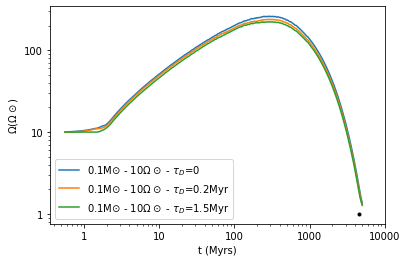

In [68]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
plt.plot(t_1p0/1e6,Omega_1p0,'-',label=r'0.1M$\odot$ - 10$\Omega\odot$ - $\tau_D$=0')
plt.plot(t_1p0_/1e6,Omega_1p0_,'-',label=r'0.1M$\odot$ - 10$\Omega\odot$ - $\tau_D$=0.2Myr')
plt.plot(t_1p0__/1e6,Omega_1p0__,'-',label=r'0.1M$\odot$ - 10$\Omega\odot$ - $\tau_D$=1.5Myr')
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

### A plot for the paper: 

Finally, I will make a plot showing a set of models for different masses that will go with the paper. The plot will have Period and Omega in the y-axis, therefore I will need this conversion function:

In [241]:
def period2omega(period):
    """
    Period in days
    """
    from astropy import units as u
    if not isinstance(period, type(1*u.d)):
        period=period*u.d
    OmegaSun=2.6e-6*u.Hz
    return 2.*np.pi/(period.to(u.s))/OmegaSun
def omega2period(Omega):
    """
    Omega in OmegaSun
    """
    from astropy import units as u
    OmegaSun=2.6e-6*u.Hz
    if not isinstance(Omega, type(1*u.Hz)):
        Omega=Omega*OmegaSun

    return 2.*np.pi*(u.s).to(u.d)/(Omega.value)

The plot will show models for mass 0.1, 0.3, 0.5, 1.0 and 1.4M$\odot$.

In [138]:
mass=[0.1,0.3,0.5,1.0,1.3]

The plot will also have different time-scales for disk-dissipation ($\tau_D$) estimated using the function I developed in the jupyter-notebook `FUV_tdisk.ipynb` and which is based on the tabulations by Andrew Winter with $\tau_{vis}=1Myrs$.

In [76]:
from SpinEvolution import get_tau_Disk

Following the values for which his models are calculated, I will consider the $\tau_D$ for $F_{FUV}$ equal to 10, 100, 1000, 5000 and 10000Go.

In [77]:
FUV=[10,100,1000,5000,10000]

This first set will use initial rotation of 1$\Omega_\odot$

In [409]:
model_1={}
to=0.56e6
t=[5e9]
e=0.01
for m in mass:
    model_1[str(m)]=[]
    spin=SpinEvolutionCode(m)
    for fuv in FUV:
        tau_D= get_tau_Disk(m,fuv)*1e6
        model_1[str(m)].append(spin.dOmegadt(m,1.*spin.Omegao,to,t,tau_d=tau_D,e=e))

/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Is $\tau_D$ in the right units?
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model


In [140]:
model_1.keys()

dict_keys(['0.1', '0.3', '0.5', '1.0', '1.3'])

In [141]:
model_10={}
for m in mass:
    model_10[str(m)]=[]
    spin=SpinEvolutionCode(m)
    for fuv in FUV:
        tau_D= get_tau_Disk(m,fuv)*1e6
        model_10[str(m)].append(spin.dOmegadt(m,10*spin.Omegao,to,t,tau_d=tau_D,e=e))

Is $\tau_D$ in the right units?
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model
Maximum value must be inside the age range of the Baraffe Model


In [142]:
model_10.keys()

dict_keys(['0.1', '0.3', '0.5', '1.0', '1.3'])

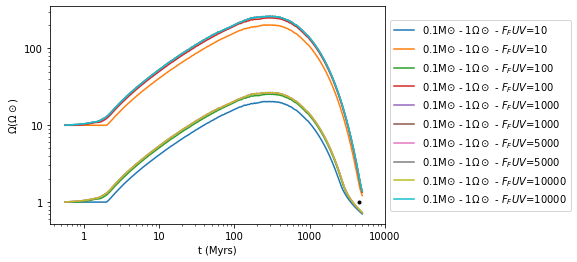

In [143]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
m=0
for i,fuv in enumerate(FUV):
    mod=model_1[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))
    mod=model_10[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))    
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

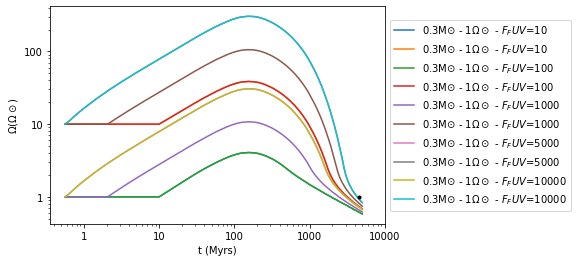

In [144]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
m=1
for i,fuv in enumerate(FUV):
    mod=model_1[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))
    mod=model_10[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))    

    
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

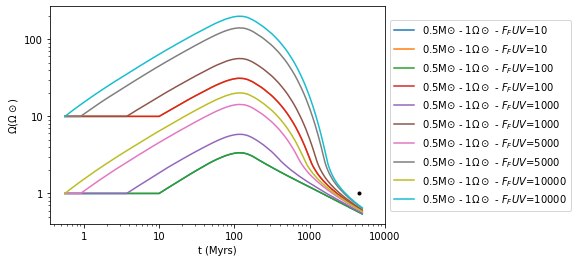

In [145]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
m=2
for i,fuv in enumerate(FUV):
    mod=model_1[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))
    mod=model_10[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))    

    
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

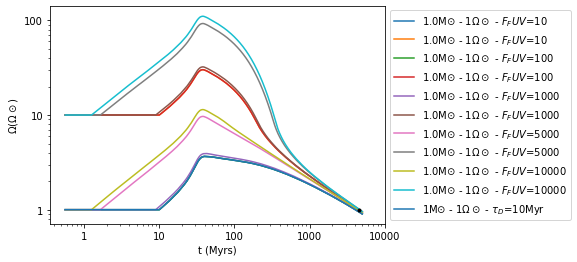

In [146]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
m=3
for i,fuv in enumerate(FUV):
    mod=model_1[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))
    mod=model_10[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))    
plt.plot(t_1p0___/1e6,Omega_1p0___,'-',label=r'1M$\odot$ - 1$\Omega\odot$ - $\tau_D$=10Myr')
    
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

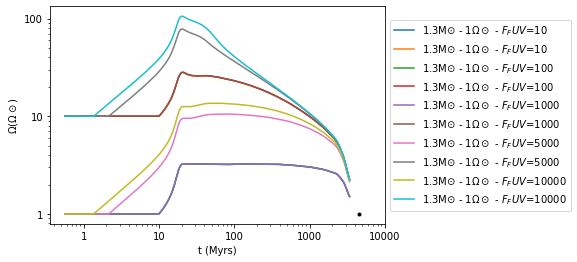

In [147]:
#e=0.01
fig, ax = plt.subplots(figsize = (6,4))#plt.plot(t,np.exp(t),label='Exact Solution')
m=4
for i,fuv in enumerate(FUV):
    mod=model_1[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))
    mod=model_10[str(mass[m])][i]
    plt.plot(mod[0]/1e6,mod[1],'-',label=r'{0}M$\odot$ - {1}$\Omega\odot$ - $F_FUV$={2}'.format(mass[m],1,fuv))    

    
plt.plot(spin.to/1e6,1,'k.')
plt.ylabel('$\Omega(\Omega\odot)$')
plt.xlabel('t (Myrs)')
plt.legend()
ax.set_xscale("log")#, nonposx='clip')
ax.set_yscale("log")#, nonposy='clip')
ax.set_xticks([1,10,100,1000,10000])
ax.set_xticklabels([1,10,100,1000,10000])
ax.set_yticks([1,10,100])
ax.set_yticklabels([1,10,100])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()
#plt.savefig('/Users/jroquette/work/plot/rotationevolutionmodel_test.png')

In [172]:
for fuv in FUV: print(np.log10(fuv))

1.0
2.0
3.0
3.6989700043360187
4.0


For more than the 4 matplolib linestyles: https://stackoverflow.com/questions/13359951/is-there-a-list-of-line-styles-in-matplotlib

In [410]:
import MacOSFile
MacOSFile.pickle_dump(model_1,'/Users/jroquette/work/data/cluster_simulations/SpinRateModels.npy')

writing total_bytes=65713...
done.
writing total_bytes=66776...
done.
writing total_bytes=65960...
done.
writing total_bytes=18679...
done.


In [222]:
color=['purple','royalblue','seagreen','gold','crimson']
dashList = [(4,8),(3,4,2,2),(5,2,20,2),(5,2),(2,5),] 

/Users/jroquette/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


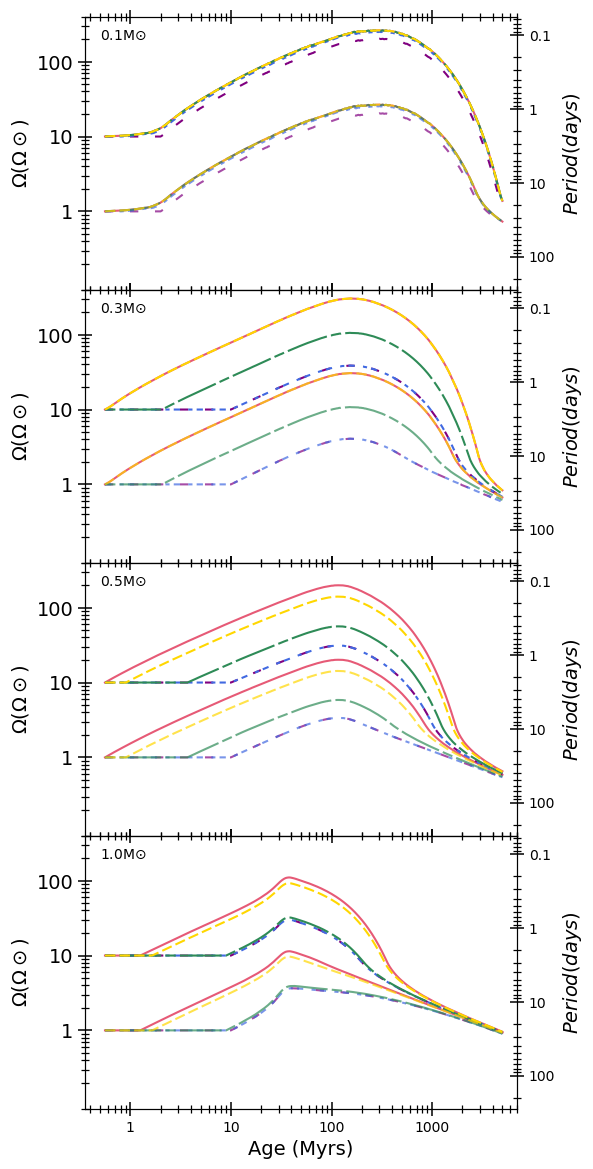

In [406]:
import matplotlib.ticker as mticker
fig,axis= plt.subplots(4,1,figsize = (6,3*4),dpi=100,sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.subplots_adjust(left=0.15, right=0.87, bottom=0.07, top=0.98)

fs=14
ax=axis[0]

for m in range(4):
    ax=axis[m]
    ax.set_xscale("log")#, nonposx='clip')
    ax.set_yscale("log")#, nonposy='clip')   
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yscale("log")
    ax2.set_xscale("log")    
    ax.text(0.5,200,str(mass[m])+r'M$\odot$')
    for i,fuv in enumerate(FUV[:-1]):
        mod=model_1[str(mass[m])][i]
        ax.plot(mod[0]/1e6,mod[1],linestyle='--',dashes=dashList[i],color=color[i],label=r'{0}'.format(fuv),alpha=0.7)
        mod=model_10[str(mass[m])][i]
        ax.plot(mod[0]/1e6,mod[1],linestyle='-.',dashes=dashList[i],color=color[i],label=r'$F_{FUV}$='+str(fuv))    
    i=4
    mod=model_1[str(mass[m])][i]
    ax.plot(mod[0]/1e6,mod[1],linestyle='-',color=color[i],label=r'{0}'.format(fuv),alpha=0.7,zorder=0)
    mod=model_10[str(mass[m])][i]
    ax.plot(mod[0]/1e6,mod[1],linestyle='-',color=color[i],label=r'$F_{FUV}$='+str(fuv),alpha=0.7,zorder=0)    
    ax.tick_params(axis="y", direction="inout", length=10, width=1.1)
    ax.tick_params(axis="x", direction="inout", length=10, width=1.1, top=True)
    ax.tick_params(axis="y",which='minor',direction="inout", length=6,width=0.9)
    ax.tick_params(axis="x",which='minor',direction="inout", length=6,width=0.9, top=True)
    ax.set_yticks([1,10,100])
    ax.set_yticklabels([1,10,100],fontsize=fs)    

    ax.set_ylabel('$\Omega(\Omega\odot)$',fontsize=fs)
    ax2.set_yticks([0.1,1,10,100])
    ax2.set_yticklabels([0.1,1,10,100])    
    ax2.set_ylim(omega2period(0.1),omega2period(500))  
    ax2.set_ylabel('$Period (days)$',fontsize=fs)
    ax.set_xticks([1,10,100,1000,10000])
    ax.set_xticklabels([1,10,100,1000,10000])
    ax2.tick_params(axis="y", direction="inout", length=10, width=1.1)
    ax2.tick_params(axis="x", direction="inout", length=10, width=1.1, top=True)
    ax2.tick_params(axis="y",which='minor',direction="inout", length=6,width=0.9)
    ax2.tick_params(axis="x",which='minor',direction="inout", length=6,width=0.9, top=True)
#ax.set_xticklabels(,fontsize=fs)

#ax.xaxis.set_major_locator(mticker.FixedLocator([1,10,100,1000]))
    
ax.set_xlabel('Age (Myrs)',fontsize=fs)


#ax.set_xlim(0,7000)
#ax.set_ylim(0.09,400)

ax.axis([0,7000,0.09,400])

# for i in [(0,0),(0,1),(1,0),(1,1)]:
#     ax=axis[i]

    

# #    ax2.set_xlim(0,7000)
# #    ax2.set_ylabel('sin')  
#     #ax2.tick_params(axis='y', labelcolor=color)

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('/Users/jroquette/work/plot/Omega_Age_model.png')